In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind, chi2_contingency, ttest_1samp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [3]:
students_performance = pd.read_csv('../data/StudentsPerformance.csv')
pd.set_option('display.max_columns', None)

# Inspecting first 5 rows of the data

In [4]:
print(students_performance.head(), '\n')

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75   



# Dataframe info

In [5]:
print(students_performance.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None 



# Proportions of specific categorical data

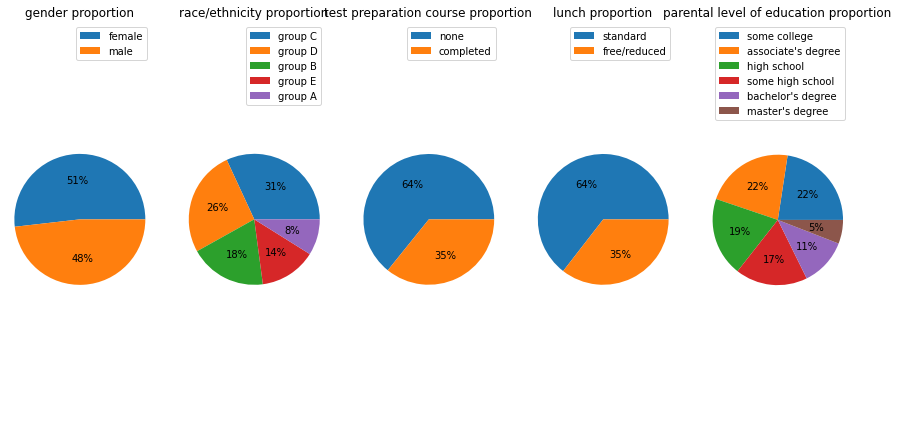

In [6]:
gender_proportion = students_performance["gender"].value_counts().reset_index()
race_proportion = students_performance["race/ethnicity"].value_counts().reset_index()
preparation_proportion = students_performance["test preparation course"].value_counts().reset_index()
lunch_proportion = students_performance["lunch"].value_counts().reset_index()
parental_education_proportion = students_performance["parental level of education"].value_counts().reset_index()
proportions = [gender_proportion, race_proportion, preparation_proportion, lunch_proportion, parental_education_proportion]

plt.figure(figsize=(12, 6))
for i, proportion in enumerate(proportions):
    plt.subplot(1, 5, i+1)
    plt.title(f'{proportion.columns[-1]} proportion')
    plt.pie(proportion.iloc[:, 1], autopct='%d%%')
    plt.axis('equal')
    plt.legend(proportion.iloc[:, 0])
plt.tight_layout()
plt.show()

# Visualize math, reading and writing score depending on ethnitical group, gender, test preparation courses, parental level of education and lunch

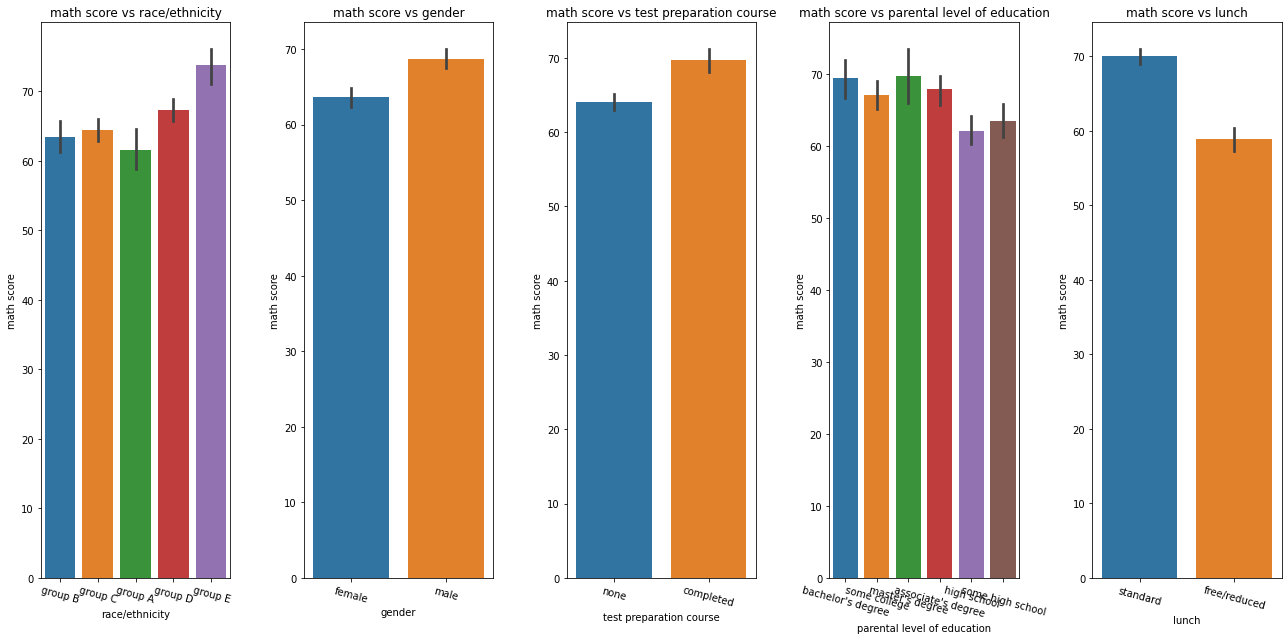

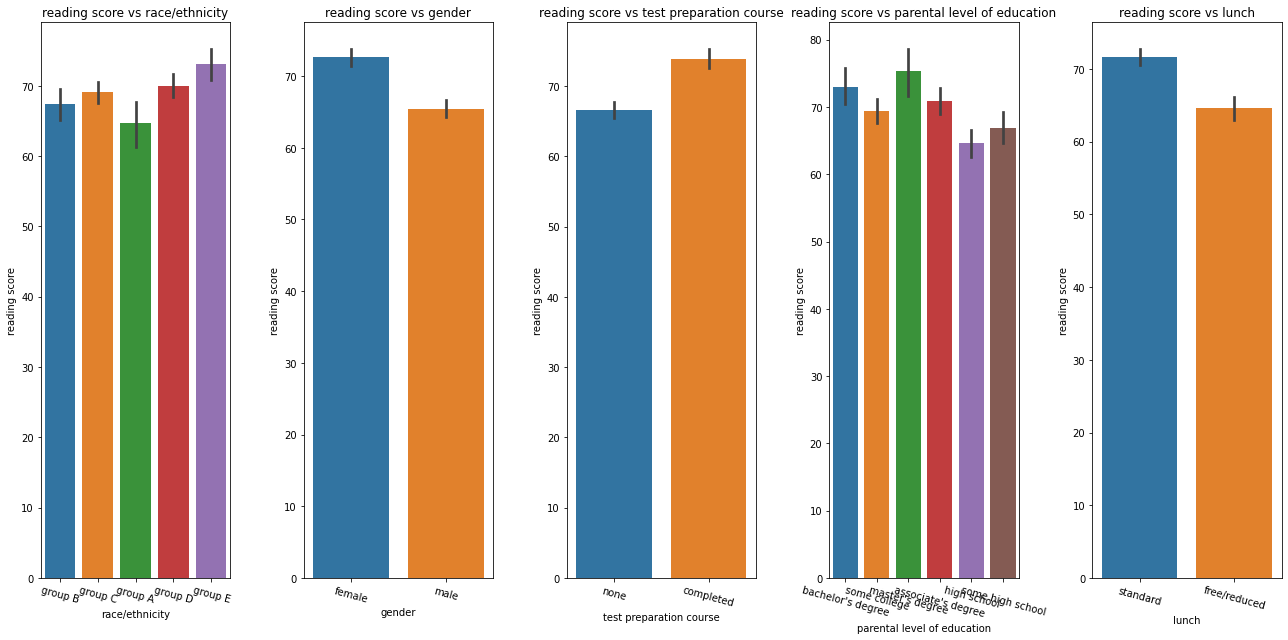

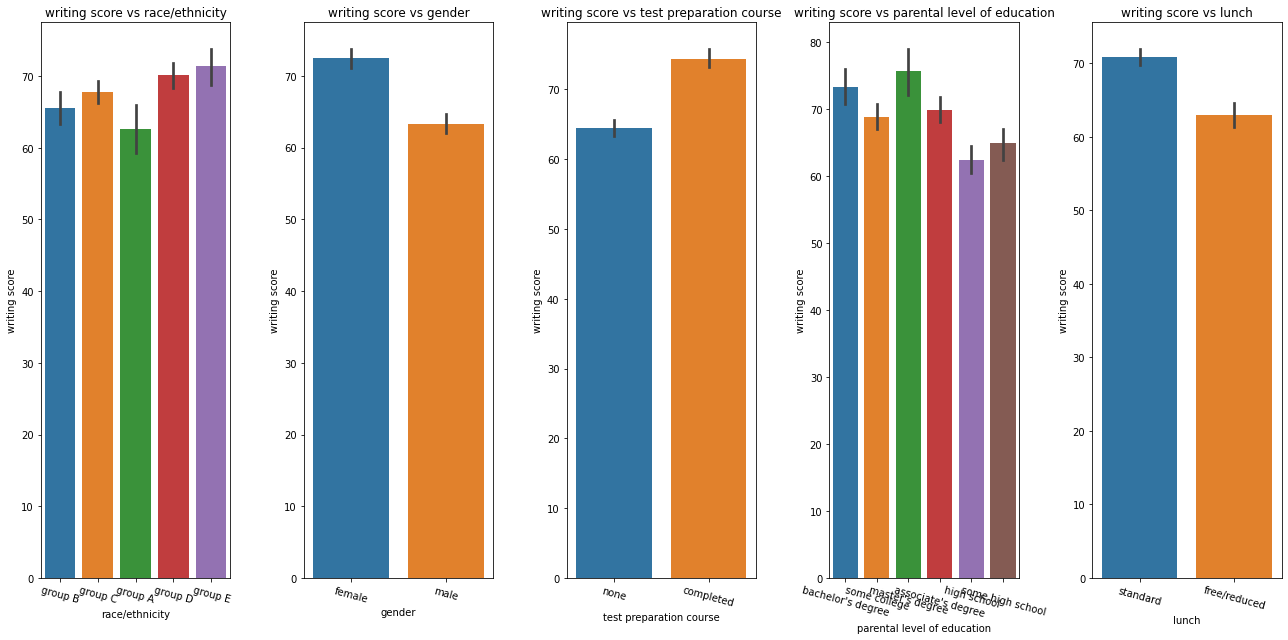

In [7]:
dependencies = ['race/ethnicity', 'gender', 'test preparation course', 'parental level of education', 'lunch']
scores = ['math score', 'reading score', 'writing score']
for result in scores:
    plt.figure(figsize=(18, 9))
    for count, dependence in enumerate(dependencies):
        plt.subplot(1, 5, count+1)
        sns.barplot(y=result, data=students_performance, x=dependence)
        plt.title(f'{result} vs {dependence}')
        plt.xticks(rotation=-15)
    plt.tight_layout()
    plt.show()

# Visualise distribution of scores dependent on gender, test preparation and ethnitical groups

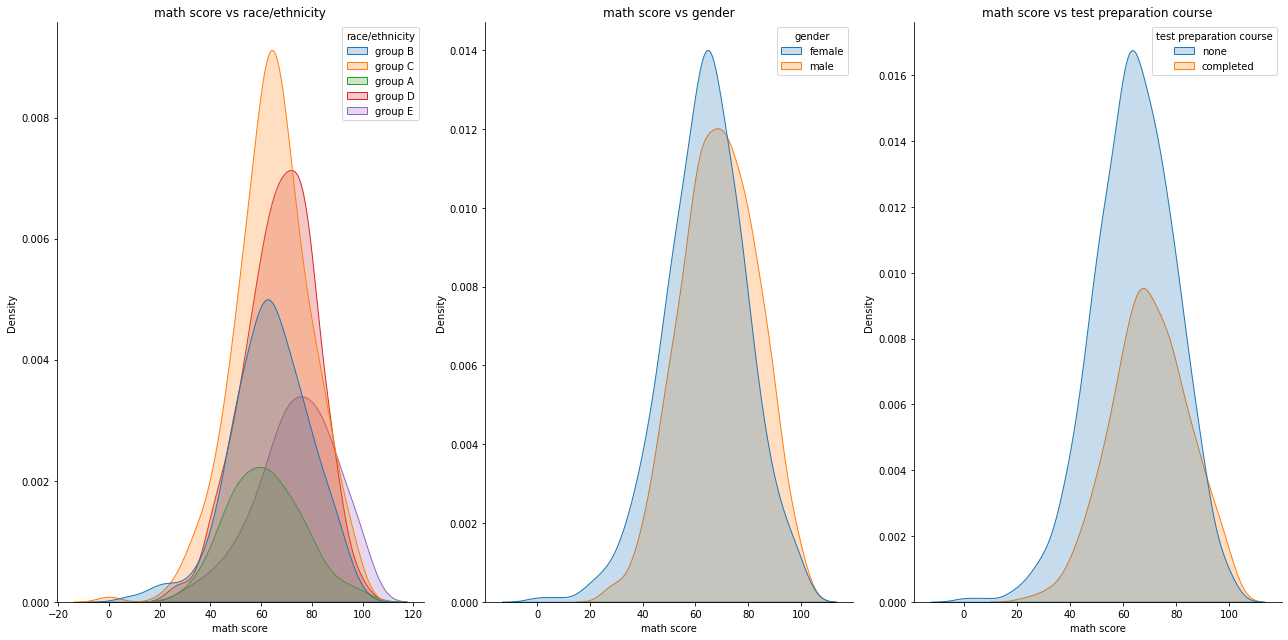

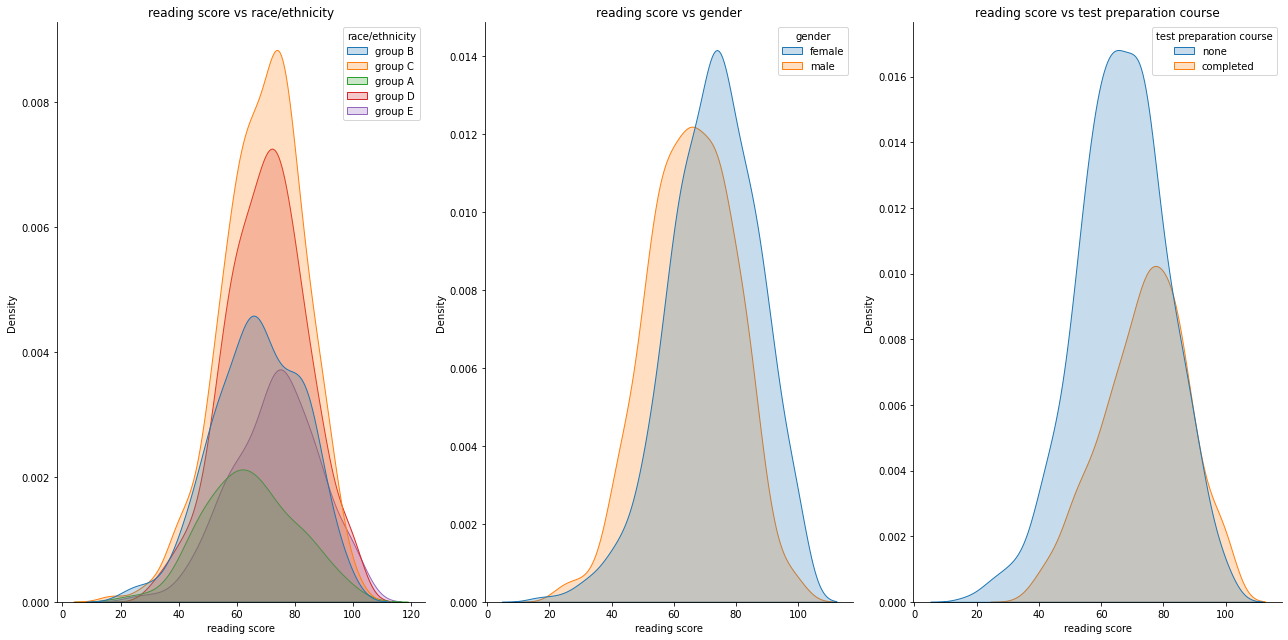

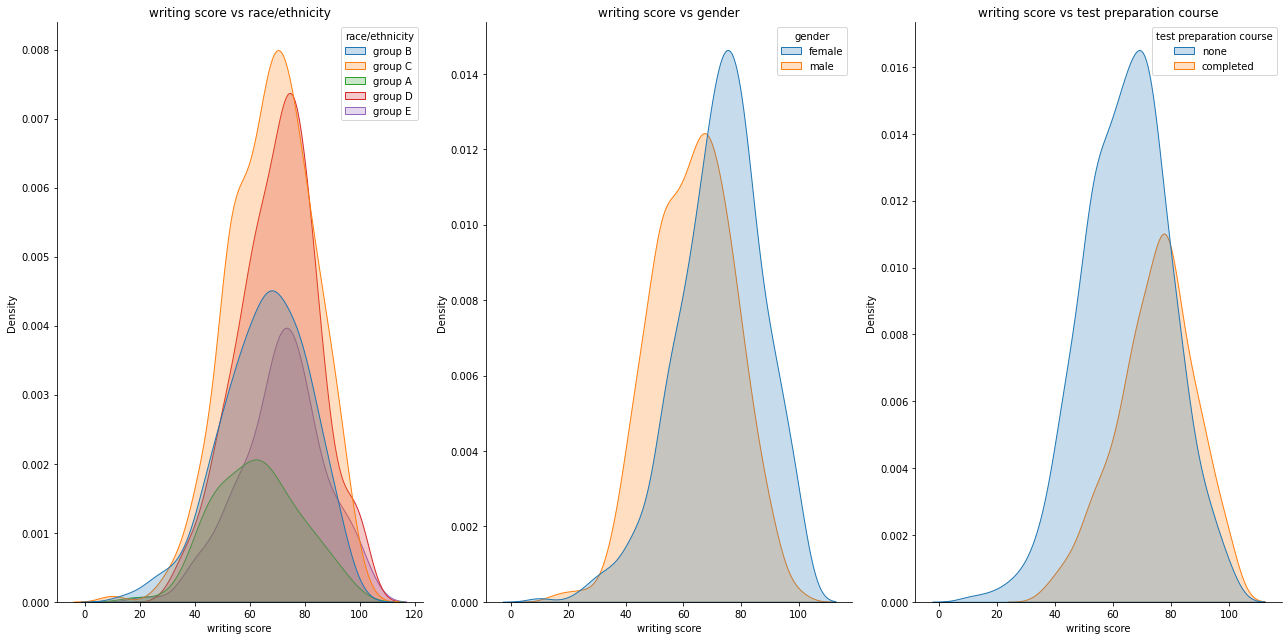

In [8]:
dependencies = ['race/ethnicity', 'gender', 'test preparation course']
for result in scores:
    plt.figure(figsize=(18, 9))
    for count, dependence in enumerate(dependencies):
        plt.subplot(1, 3, count + 1)
        sns.kdeplot(result, data=students_performance, hue=dependence, shade=True)
        plt.title(f'{result} vs {dependence}')
        sns.despine()
    plt.tight_layout()
    plt.show()

# Our distributions are normal, we need to check one more assumption in order to complete hypothesis testing
- Check difference in standard deviation

In [9]:
completed_preparation = students_performance[students_performance['test preparation course'] == 'completed']
none_preparation = students_performance[students_performance['test preparation course'] == 'none']

male_performance = students_performance[students_performance['gender'] == 'male']
female_performance = students_performance[students_performance['gender'] == 'female']

groupA_performance = students_performance[students_performance['race/ethnicity'] == 'group A']
groupB_performance = students_performance[students_performance['race/ethnicity'] == 'group B']
groupC_performance = students_performance[students_performance['race/ethnicity'] == 'group C']
groupD_performance = students_performance[students_performance['race/ethnicity'] == 'group D']
groupE_performance = students_performance[students_performance['race/ethnicity'] == 'group E']

- Check difference in standard deviation in scores of gender

In [10]:
male_scores_std = np.std(male_performance)
female_scores_std = np.std(female_performance)
difference_scores_std_gender = abs(male_scores_std - female_scores_std)
print('Difference of standard deviation of genders:\n', difference_scores_std_gender, '\n')

Difference of standard deviation of genders:
 math score       1.135116
reading score    0.446988
writing score    0.731323
dtype: float64 



- Standart deviation of scores by genders are about to be the same

- Check difference in standard deviation in scores by test preparation

In [11]:
completed_preparation_scores_std = np.std(completed_preparation)
none_preparation_scores_std = np.std(none_preparation)
difference_scores_std_courses = abs(completed_preparation_scores_std - none_preparation_scores_std)
print('Difference of standard deviation of courses:\n', difference_scores_std_courses, '\n')

Difference of standard deviation of courses:
 math score       0.756028
reading score    0.833294
writing score    1.631334
dtype: float64 



- Standard deviation of scores are about to be the same except writing scores (1.63 difference)

- Check difference in standard deviation in scores of race groups

In [12]:
groupA_scores_std = np.std(groupA_performance)
groupB_scores_std = np.std(groupB_performance)
groupC_scores_std = np.std(groupC_performance)
groupD_scores_std = np.std(groupD_performance)
groupE_scores_std = np.std(groupE_performance)
difference_scores_std_race = abs(groupE_scores_std - groupA_scores_std - groupD_scores_std - groupC_scores_std - groupB_scores_std)
print('Difference of standard deviation of races:\n', difference_scores_std_race, '\n')

Difference of standard deviation of races:
 math score       42.962391
reading score    43.616729
writing score    45.205436
dtype: float64 



- There is a big difference in spread, so we can not check hypothesis on this data

# Testing association between test preparation and scores

In [13]:
tstat, test_prep_pval = ttest_ind(completed_preparation[scores], none_preparation[scores])
print('''
H0 - mean score of students who completed course and not are the same.
HA - mean score of students who completed course and not are not the same.
''')
for score, result in enumerate(test_prep_pval):
    if result < 0.05:
        print(f'For {scores[score]} we accept that they have different mean score.')
    else:
        print(f'For {scores[score]} we accept that they have the same mean score.')


H0 - mean score of students who completed course and not are the same.
HA - mean score of students who completed course and not are not the same.

For math score we accept that they have different mean score.
For reading score we accept that they have different mean score.
For writing score we accept that they have different mean score.


### THERE IS A BIG DIFFERENCE IN MEAN SCORES OF STUDENT WHO COMPLETED EXTRA COURSES AND NOT ###

In [14]:
#Inspecting the mean values of student who completed course and not completed
completed_preparation_scores_mean = np.mean(completed_preparation)
none_preparation_scores_mean = np.mean(none_preparation)
print(f'Mean for students who completed courses\n{completed_preparation_scores_mean}\nMean for those who not completed courses\n{none_preparation_scores_mean}')

Mean for students who completed courses
math score       69.695531
reading score    73.893855
writing score    74.418994
dtype: float64
Mean for those who not completed courses
math score       64.077882
reading score    66.534268
writing score    64.504673
dtype: float64


# In average those students who completed courses has more scores than those who does not complete courses

# Check association between gender and test results

In [15]:
tstat, gender_scores_pval = ttest_ind(male_performance[scores], female_performance[scores])
print('''
H0 - mean score of students of both genders are the same.
HA - mean score of students of both genders are not the same.
''')
for score, result in enumerate(gender_scores_pval):
    if result < 0.05:
        print(f'For {scores[score]} we accept that both genders have different mean score.')
    else:
        print(f'For {scores[score]} we accept that both genders have the same mean score.')


H0 - mean score of students of both genders are the same.
HA - mean score of students of both genders are not the same.

For math score we accept that both genders have different mean score.
For reading score we accept that both genders have different mean score.
For writing score we accept that both genders have different mean score.


# Inspecting mean value of scores by genders

In [16]:
male_scores_mean = np.mean(male_performance)
female_scores_mean = np.mean(female_performance)
print(f'Mean of scores for male \n{completed_preparation_scores_mean}\nMean of scores for female \n{none_preparation_scores_mean}')
#In average male student have more math score but have less reading and writing score

Mean of scores for male 
math score       69.695531
reading score    73.893855
writing score    74.418994
dtype: float64
Mean of scores for female 
math score       64.077882
reading score    66.534268
writing score    64.504673
dtype: float64


# In average male student has bigger math score but have smaller reading and writing score than female student

# Association between race/ethnicity and parental level of education

In [17]:
#Cross tabulation of race/ethnicity and parental level of education
race_education_tab = pd.crosstab(students_performance['race/ethnicity'], students_performance['parental level of education'])
#Association between race/ethnicity and parental level of education
chi2, race_education_pval, dof, exp = chi2_contingency(race_education_tab)
print('''
H0 - there is an association parental level of education and ethnicity group.
HA - there is no association between parental level of education and writing ethnicity group.
''')
result = 'Reject H0' if race_education_pval < 0.05 else "Accept H0"
print(f"Chi2: {chi2}, confident level: {race_education_pval}\n")
print(result)


H0 - there is an association parental level of education and ethnicity group.
HA - there is no association between parental level of education and writing ethnicity group.

Chi2: 29.45866151909779, confident level: 0.07911304840592065

Accept H0


# Which parameters have more influence on scores? We can use Linear Regression to check this

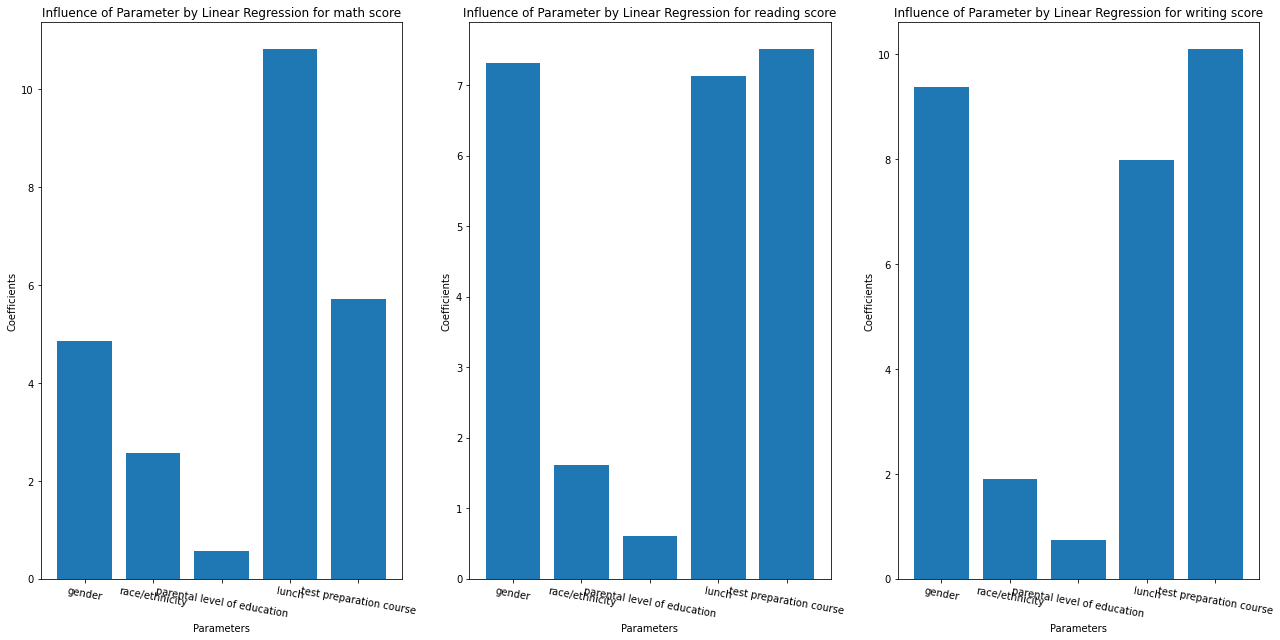

In [19]:
plt.figure(figsize=(18, 9))
for i, score in enumerate(scores):
    feature_set = students_performance.drop(scores, axis=1)
    for column in feature_set.columns:
        encoder = LabelEncoder()
        feature_set[column] = encoder.fit_transform(feature_set[column])
    target = students_performance[score]
    linear_model = LinearRegression().fit(feature_set, target)
    ax = plt.subplot(1, 3, i+1)
    coefficients = abs(linear_model.coef_)
    x_values = range(len(coefficients))
    plt.bar(x_values, coefficients)
    plt.title(f'Influence of Parameter by Linear Regression for {score}')
    plt.ylabel('Coefficients')
    plt.xlabel('Parameters')
    plt.xticks(rotation=-10)
    ax.set_xticks(x_values)
    ax.set_xticklabels(feature_set.columns)
plt.tight_layout()
plt.show()